# Tutorial on Encoding Models with Word Embeddings
originally for NeuroHackademy 2020, by Alex Huth

In [1]:
# Load some basic stuff we'll need later
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Part 1: Regression: what is it? Why would you use it?

I'm interested in "predictive" models of brain responses. Suppose you do an experiment where you're recording some kind of brain responses, let's call them $y(t)$, while you provide your experimental subject with some kind of stimulus, let's call that $s(t)$. I think you can claim to understand something about what the brain is doing if you can build a model that predicts $y(t)$ from $s(t)$. (I think this claim is especially true if $s(t)$ is a "natural" stimulus, i.e. something that you would expect to see in everyday life, rather than something concocted specifically in a laboratory.)

How do we build a model that predicts $y(t)$ from $s(t)$? There are lots of approaches! But they all use one core concept: **_regression_**.

You do regression like this:
### 1. Extract features ###
You say "I can break $s(t)$ into different parts, or features". This transforms $s(t)$ into some other representation that we'll call $x(t)$. Let's say that the number of features in $x(t)$ is $p$.

### 2. Define the model ###
You say "I can predict $y(t)$ from a weighted combination of the features in $x(t)$". This means you are imagining a model that looks something like this,

$$y(t) = \sum_{i=1}^p x_i(t) \beta_i + \epsilon(t),$$
where:
* $x_i(t)$ refers to the $i$th feature in $x(t)$, 
* $\beta_i$ refers to the weight on that feature (we don't know what this weight is yet), and 
* $\epsilon(t)$ refers to the noise, i.e. any part of $y(t)$ that you can't predict from $x(t)$ (we don't know what this is yet either).

Since this model is just a weighted sum, we can write it more simply using a little linear algebra,
$$y(t) = x(t) \beta + \epsilon(t),$$
where $x(t)$ is now a $1 \times p$ vector of feature values and $\beta$ is a $p \times 1$ vector of weights.

To deal with these equations more easily, we'll need to stack the values of $y(t)$ and $x(t)$ into matrices. Let's define those matrices like this:

$$Y = \begin{bmatrix} y(t=1) \\ y(t=2) \\ \vdots \\ y(t=T) \end{bmatrix}, \;
X = \begin{bmatrix} x(t=1) \\ x(t=2) \\ \vdots \\ x(t=T) \end{bmatrix} $$

So we now have $Y$, which is a $T \times 1$ matrix of brain responses, and $X$, which is a $T \times p$ matrix of features that we extracted from the stimuli. If we also define $\epsilon$ as a vector of the same size as $Y$, then we can re-write the model like this:

$$ Y = X \beta + \epsilon $$

Let's make some fake data using this model!

In [2]:
# Let's set up a simple regression! First we'll create some fake stimulus & "true" weights

T_train = 100 # number of timepoints in our model training dataset
p = 5 # number of features
noise_size = 5.0 # the standard deviation of the noise, epsilon

X_train = np.random.randn(T_train, p) # random Gaussian-distributed (normal) numbers
print("X_train",X_train.shape)

beta_true = np.random.randn(p)
print("beta_true",beta_true.shape)

Y_train = X_train.dot(beta_true) + noise_size * np.random.randn(T_train) # Y = X beta + epsilon
print("Y_train",Y_train.shape)

X_train (100, 5)
beta_true (5,)
Y_train (100,)


### 3. Estimate the model weights, $\beta$ ###
You say "I need to find the weights $\beta$ that make my model good at predicting $y(t)$". Here's where the magic is! To do this we're first going to define a **_loss function_** $\mathcal{L}(\beta)$, which tells us how good our model is for any particular value of the weight vector $\beta$. (It's called a loss function because bigger values == bigger loss == a worse model. So we want the loss function to be as small as possible.)

First, let's start by converting the sum in $\mathcal{L}(\beta)$ into a matrix multiplication. 

The most common loss function (and best, in most situations) is **squared error loss**, which looks like this:
$$\mathcal{L}(\beta) = \sum_{t=1}^T (y(t) - x(t) \beta)^2 $$

or, in matrix terms:

$$ \mathcal{L}(\beta) = (Y - X\beta)^\top (Y - X \beta) $$
(If it's not clear why this is equivalent to our first expression for the loss function, try to re-imagine this equation as a summation across timepoints.)

Using this function you can now try to find the best values for $\beta$! Our goal here is to find the value of $\beta$ that minimizes the loss function. Think back to when you first learned calculus.. do you remember learning how to find the minimum of a function? In particular, our loss function is actually a parabola (why?), which means it has (approximately) one minimum! We can find this minimum by taking the derivative of the loss function with respect to $\beta$, and then finding the value of $\beta$ that sets the derivative to zero.

We can expand the multiplication in our loss function:
$$ \mathcal{L}(\beta) = Y^\top Y - 2 Y^\top X \beta + \beta^\top X^\top X \beta $$
Taking the derivative then gives us this expression:
$$\frac{d \mathcal{L}(\beta)}{d \beta} = -2 Y^\top X + 2 \beta^\top X^\top X $$
Here, the $Y^\top Y$ term disappeared because it didn't depend on $\beta$. If you want to know how the other terms came about, you might want to peruse the [somewhat baroque rules of matrix calculus](https://en.wikipedia.org/wiki/Matrix_calculus).

Now to find the best value of $\beta$ we need to set $\frac{d \mathcal{L}(\beta)}{d \beta} = 0$ and then solve for $\beta$:
$$\begin{eqnarray}
\frac{d \mathcal{L}(\beta)}{d \beta} &=& 0 \\
-2 Y^\top X + 2 \beta^\top X^\top X &=& 0 \\
\beta^\top X^\top X &=& Y^\top X \\
X^\top X \beta &=& X^\top Y \mbox{  (transposed both sides)} \\
\beta &=& (X^\top X)^{-1} X^\top Y
\end{eqnarray}$$

And there we have it! The best possible weights for predicting $y(t)$ from $x(t)$ are given by this neat little expression: $\beta = (X^\top X)^{-1} X^\top Y$.

Going forward, we're going to refer to this regression procedure as **_ordinary least squares_** or **_OLS_**, and the solution that we derived as "the OLS solution" or $\beta_{OLS}$.

Let's try this procedure out on some fake data, then some real data from an fMRI experiment!

In [3]:
# First let's solve the regression exactly using the formula from above

beta_estimate_1 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(Y_train)
print("estimated:", beta_estimate_1)
print("true:", beta_true)

estimated: [ 1.86579717  0.28402444  0.90892622 -0.21948709 -0.64389185]
true: [ 1.43391177  0.43310327  0.70413858 -0.54228685 -1.37902948]


## Outrageously important concept: _testing your model on held-out data_
How do you know how good your regression model is? The estimated weights look _kind of_ like the true weights, but in the real world you don't know what the real weights are!

One option would be to test how well your model fit your original (training) dataset. That would be a bad option. We'll get into why in the next module.

The _correct_ option is to test how well your model can predict _new_ data, on which the model was not trained. Let's do that here, by generating some more data using our 'true' weights!

In [4]:
# generate new data to test the model on

T_test = 25 # number of timepoints for our new test dataset

X_test = np.random.randn(T_test, p)
Y_test = X_test.dot(beta_true) + noise_size * np.random.randn(T_test)

### How do we evaluate our model?
There are many ways! We're going to use one: [linear correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

In [5]:
# Now let's test how well this model is able to predict the held-out test data
Y_test_pred = X_test.dot(beta_estimate_1)

print("Correlation between true & predicted Y_test:", np.corrcoef(Y_test, Y_test_pred)[0,1])

Correlation between true & predicted Y_test: 0.37491783818647706


In [6]:
# In practice you should really not use the formula that has an explicit inverse for doing OLS
# this has to do with numerical stability, something that ideally you shouldn't concern yourself with
# instead we'll use a function that numpy includes explicitly for this purpose!
# at its core, it uses a singular value decomposition (SVD) instead of explicit matrix inversion
# this is much more stable!

beta_estimate_2 = np.linalg.lstsq(X_train, Y_train)[0]
print("estimated:", beta_estimate_1)
print("estimated:", beta_estimate_2)
print("true:", beta_true)

# (for this simple case, though, the answer should be ~identical to what you found previously)

estimated: [ 1.86579717  0.28402444  0.90892622 -0.21948709 -0.64389185]
estimated: [ 1.86579717  0.28402444  0.90892622 -0.21948709 -0.64389185]
true: [ 1.43391177  0.43310327  0.70413858 -0.54228685 -1.37902948]


/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


## OLS for an fMRI analysis

Let's try to use this method now for an [fMRI experiment](https://www.nature.com/articles/nature17637). In this experiment, each subject listened to 11 different natural, narrative stories over headphones while we recorded BOLD signals continuously (well, every 2 seconds) using fMRI. The first 10 of these stories will comprise the _training set_, on which we will learn our regression models. The last story will comprise the _test set_, on which we will test our models.

The model that we are going to fit is quite simple. Our stimulus (what we call $s(t)$) is a set of audio stories. The features that we have extracted from these stories (what we call $x(t)$) are indicator variables that show which words were spoken at each timepoint (here timepoints correspond to the fMRI volumes, so each one represents a 2 second period).

We're going to skip a lot of the preprocessing steps here and load data that's _almost_ already set up for regression.

In [8]:
# first let's load up the list of unique words that appear in the stories
import tables
word_tf = tables.open_file('/Users/clmnlab/Downloads/data/we_word_embeddings/small_english1000sm.hdf5')
words = word_tf.root.vocab.read()
word_tf.close()

In [9]:
words

array([b'', b'four', b'hanging', ..., b'incredibly', b'june',
       b'expletives'], dtype='|S16')

In [10]:
# now let's load up the feature matrices
# these were stored as "sparse" matrices in order to save space
# but we'll convert them back to normal matrices in order to use them in our regression
from scipy import sparse
training_features = sparse.load_npz('/Users/clmnlab/Downloads/data/we_word_embeddings/indicator_Rstim.npz').todense().A
test_features = sparse.load_npz('/Users/clmnlab/Downloads/data/we_word_embeddings/indicator_Pstim.npz').todense().A

In [11]:
training_features.shape, test_features.shape
# these should have different numbers of timepoints (3737 for training, 291 for test)
# but the same number of feature dimensions for both (2702)

((3737, 2702), (291, 2702))

In [12]:
# we can see which words appeared in each timepoint of the fMRI data like this
# (this is a list of all the words appearing in a 2-second segment, out of order!)
words[training_features[123] > 0]

array([b'love', b'so', b'really', b'on', b'decided', b'it', b'yes',
       b'finally', b'get', b'good', b"it's", b'like', b'about'],
      dtype='|S16')

In [13]:
# now let's load up the brain responses
response_tf = tables.open_file('/Users/clmnlab/Downloads/data/we_word_embeddings/small-fmri-responses.hdf5')
training_resp = response_tf.root.zRresp.read()
test_resp = response_tf.root.zPresp.read()
brain_mask = response_tf.root.mask.read()
response_tf.close()

In [14]:
training_resp.shape, test_resp.shape
# these should have the same number of timepoints as the features (3737 for training, 291 for test)
# the other dimension is the number of voxels (5156 here)

((3737, 5156), (291, 5156))

In [15]:
# to accurately predict BOLD responses we need to account for hemodynamic delays
# we'll do that here by creating multiple time-shifted versions of the same stimulus
# this is called a finite impulse response or FIR model

from util import make_delayed
delays = [1,2,3,4]

del_training_features = make_delayed(training_features, delays)
del_test_features = make_delayed(test_features, delays)

In [16]:
del_training_features.shape, del_test_features.shape
# these should have the same number of timepoints as before, but now the number of features
# should be increased by a factor of 4 (to 10808)

((3737, 10808), (291, 10808))

In [17]:
# then we can fit our regression models!

beta_ols = np.linalg.lstsq(del_training_features, training_resp)[0]

/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
beta_ols.shape
# should be total number of features (10808) by number of voxels (5156)

(10808, 5156)

In [19]:
# now let's test our regression models on the held-out test data
pred_test_resp = del_test_features.dot(beta_ols)

import npp # a set of convenience functions I think are missing from numpy :)

test_correlations = npp.mcorr(test_resp, pred_test_resp) # computes the correlation for each voxel

In [20]:
test_correlations.shape
# should be a vector with one value per voxel (5156)

(5156,)

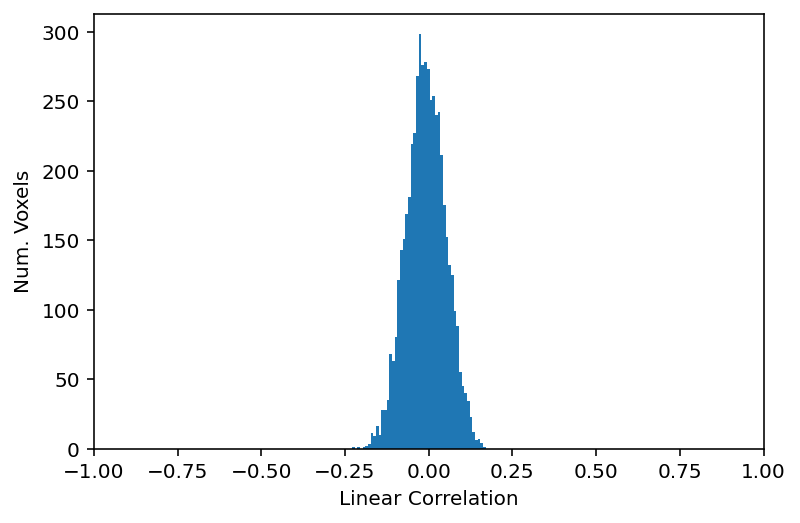

In [21]:
# let's look at the histogram of correlations!
plt.hist(test_correlations, 50)
plt.xlim(-1, 1)
plt.xlabel("Linear Correlation")
plt.ylabel("Num. Voxels");

FileNotFoundError: [Errno 2] No such file or directory: 'build/bdist.macosx-10.9-x86_64/wheel/pycortex-1.2.0.data/data/share/pycortex/db/S1/surfaces'

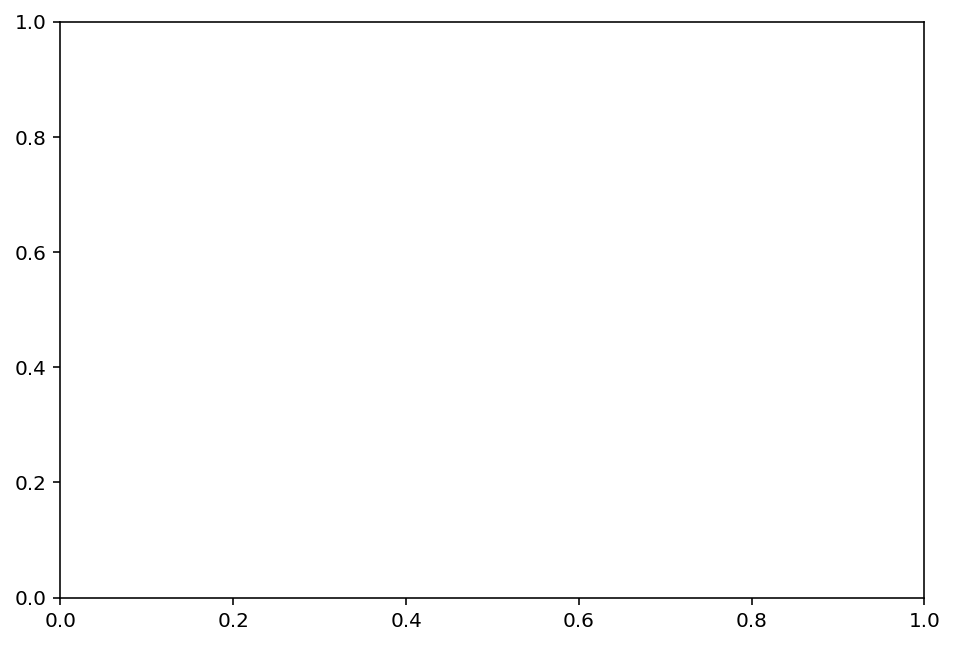

In [27]:
# Yikes that doesn't look too good! It doesn't seem like we were able to predict much of anything here :(
# to be sure, let's look at a brain map of the correlations!

import cortex

corr_volume = cortex.Volume(test_correlations, 'S1', 'fullhead', mask=brain_mask, vmin=-0.3, vmax=0.3, cmap='RdBu_r')
cortex.quickshow(corr_volume);

In [ ]:
# you can also look at it in 3D!

cortex.webshow(corr_volume, open_browser=False)

# That's it for OLS 👎
It did not work well. Let's improve things in the next module!